
## Marketing Campaign Analysis Project

### Project Overview
#
This project involves a detailed analysis of customer marketing data to understand the factors that influence purchasing behavior and campaign success. The process includes data cleaning, feature engineering, exploratory data analysis, hypothesis testing, and creating visualizations to answer specific business questions.
#
1.Setup and Data Loading
#
First, we'll import the necessary libraries for data manipulation, analysis, and visualization. Then, we'll load the dataset.




In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('marketing_data.csv')

# Display basic info and check for null values
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isna().sum())



ModuleNotFoundError: No module named 'pandas'

2- Data Cleaning and Preparation
In this section, we will clean and prepare the data for analysis. This includes:
1.  Fixing Data Types: Correcting the `Income` and `Dt_Customer` columns.
2.  Imputing Missing Values: Filling in missing Income values based on education and marital status.
3.  Standardizing Categories: Consolidating categories in Marital_Status and Education for better analysis.
#
2.1 Fix Data Types for `'Income'` and `'Dt_Customer'`
The 'Income' column has extra spaces, '$', and commas.
We will remove them and convert the column to a numeric type.



In [4]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Clean Income column: remove '$' and ',' and convert to float
df['Income'] = df['Income'].replace(r'[\$,]', '', regex=True).astype(float)

# Fill missing Income using group-wise median by Education and Marital_Status
grp_median = df.groupby(['Education', 'Marital_Status'])['Income'].transform('median')
df['Income'] = df['Income'].fillna(grp_median).fillna(df['Income'].median())

# Sanity check for missing income values
missing_count = df['Income'].isnull().sum()
assert missing_count == 0, f"There are still {missing_count} missing incomes!"
print("✅ No missing income values after imputation.")

# Optional: show head after cleaning
print(df.head())

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%y', errors='coerce')
# Check for any NaT values in Dt_Customer
nat_count = df['Dt_Customer'].isna().sum()
assert nat_count == 0, f"There are {nat_count} invalid dates in Dt_Customer!"
print("✅ All dates in Dt_Customer are valid.")
# Standardize Marital_Status categories
marital_mapping = {
    'Single': 'Single',
    'Married': 'Married',
    'Together': 'Married',
    'Divorced': 'Divorced',
    'Widow': 'Divorced',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
}
df['Marital_Status'] = df['Marital_Status'].replace(marital_mapping)
# Standardize Education categories


education_mapping = {
    'PhD': 'PhD',
    'Master': 'Master',
    'Graduation': 'Graduation',
    '2n Cycle': 'Graduation',  
    'Basic': 'Basic',

}
df['Education'] = df['Education'].replace(education_mapping)

# Calculate tenure in days from a fixed date for consistency
end_date = pd.to_datetime('2025-07-23')
df['customer_tenure_days'] = (end_date - df['Dt_Customer']).dt.days

# Example: Create a 'children_count' column (if you have Kidhome/Teenhome)
df['children_count'] = df['Kidhome'] + df['Teenhome']

# Example: Create a binary 'has_children' column
df['has_children'] = (df['children_count'] > 0).astype(int)

# Check how many duplicate rows exist
print(f"Found {df.duplicated().sum()} duplicate rows.")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

✅ No missing income values after imputation.
      ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0   1826        1970  Graduation       Divorced  84835.0        0         0   
1      1        1961  Graduation         Single  57091.0        0         0   
2  10476        1958  Graduation        Married  67267.0        0         1   
3   1386        1967  Graduation       Together  32474.0        1         1   
4   5371        1989  Graduation         Single  21474.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumStorePurchases  NumWebVisitsMonth  \
0     6/16/14        0       189  ...                  6                  1   
1     6/15/14        0       464  ...                  7                  5   
2     5/13/14        0       134  ...                  5                  2   
3     5/11/14        0        10  ...                  2                  7   
4      4/8/14        0         6  ...                  2                  7   

   Ac

3. Feature Engineering
Now, we'll create new features to help with our analysis:
-   `Age`: Customer's age.
-   `TotalChildren`: Total number of children and teenagers at home.
-   `TotalSpending`: Sum of spending on all product categories.
-   `TotalPurchases`: Sum of purchases from all channels.
#
3.1 Create New Variables
#
 We will use `2015` as the reference year for age calculation, as it's just after the latest customer signup date.


In [6]:
# Create Age (using the current year 2015 for calculation)
df['Age'] = 2015 - df['Year_Birth']

# Create TotalChildren
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']

# Create TotalSpending
spending_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds'
]
df['TotalSpending'] = df[spending_cols].sum(axis=1)

# Create TotalPurchases
purchase_cols = [
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'
]
df['TotalPurchases'] = df[purchase_cols].sum(axis=1)

Age               0.349944
TotalChildren     0.415970
TotalSpending     0.860841
TotalPurchases    0.297114
dtype: float64


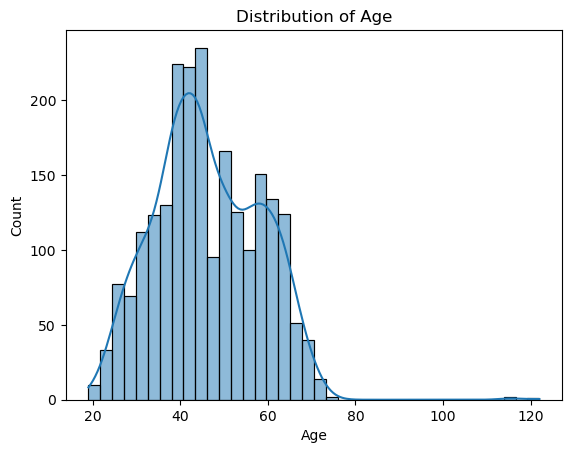

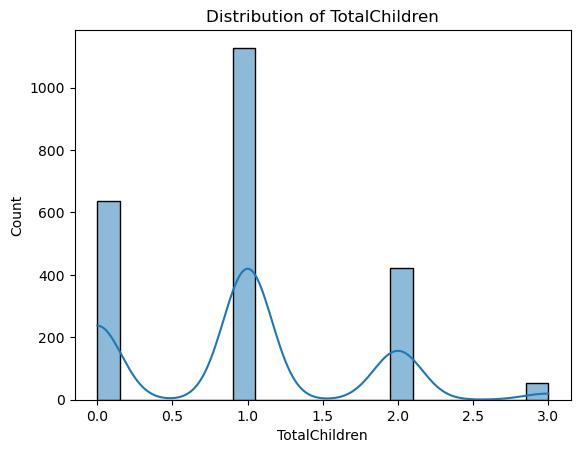

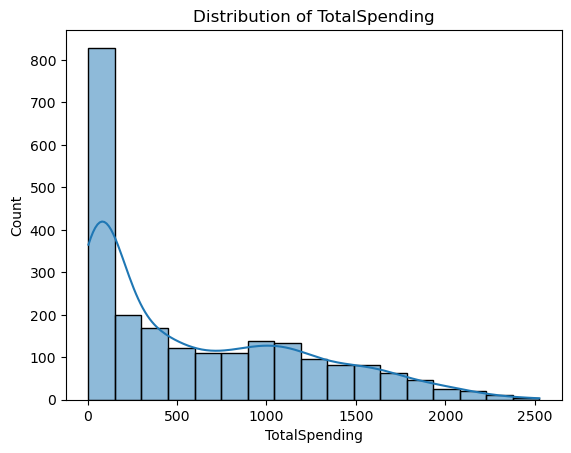

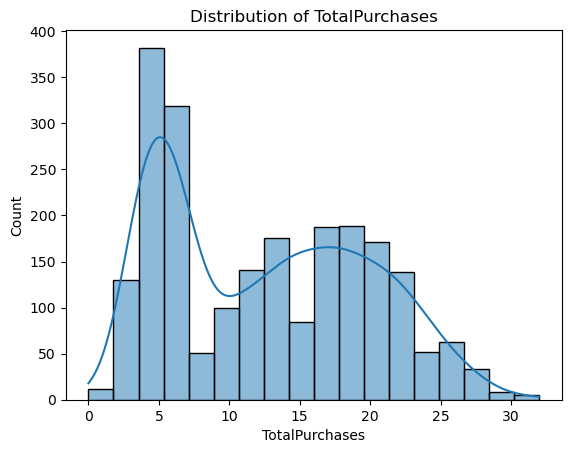

In [7]:
# Define the new list of columns to check
columns_to_check = [
    'Age',
    'TotalChildren',
    'TotalSpending',
    'TotalPurchases',
]

#  Calculate skewness for the specified columns
specific_skewness = df[columns_to_check].skew()

# Print the result
print(specific_skewness)
# Visualize all distributions
for col in columns_to_check:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [9]:
import numpy as np

# Apply a log transformation to the 'TotalSpending' column
# We add 1 to handle any potential zero values, which is called a log(x+1) transform
df['total_spending_log'] = np.log(df['TotalSpending'] + 1)
df['total_spending_log'].skew()


-0.3710595125521856


4. Outlier Treatment
#
To prevent extreme values from skewing the results, we will identify and remove outliers from the Age and Income columns. We'll consider any `age` over `100` or an `income` over `$200,000` as an outlier for this analysis.




In [10]:
# 4.1 Remove Outliers
print(f"Original dataset size: {df.shape[0]} rows")

# Filter out rows where age is greater than 100 or income is greater than 200,000
df_clean = df[(df['Age'] < 100) & (df['Income'] < 200000)].copy()

print(f"Cleaned dataset size after removing outliers: {df_clean.shape[0]} rows")
# --- Data Encoding ---
# One-hot encode the categorical variables for modeling
categorical_cols = ['Education', 'Marital_Status', 'Country']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

print("Shape of the dataframe after encoding:", df_encoded.shape)
df_encoded.head()

Original dataset size: 2240 rows
Cleaned dataset size after removing outliers: 2236 rows
Shape of the dataframe after encoding: (2236, 45)


,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_PhD,Marital_Status_Married,Marital_Status_Single,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US
0,1826,1970,84835.0,0,0,2014-06-16,0,189,104,379,...,False,False,False,False,False,False,False,False,True,False
1,1,1961,57091.0,0,0,2014-06-15,0,464,5,64,...,False,False,True,True,False,False,False,False,False,False
2,10476,1958,67267.0,0,1,2014-05-13,0,134,11,59,...,False,True,False,False,False,False,False,False,False,True
3,1386,1967,32474.0,1,1,2014-05-11,0,10,0,1,...,False,True,False,False,False,False,False,False,False,False
4,5371,1989,21474.0,1,0,2014-04-08,0,6,16,24,...,False,False,True,False,False,False,False,False,True,False


### Data Encoding

To prepare our categorical data for analysis, we will use two encoding strategies:

- **One-Hot Encoding**: For `Marital_Status` and `Country`, we used one-hot encoding. These categories are nominal and have no intrinsic rank, so this method prevents the model from incorrectly assuming an order.
- **Ordinal Encoding**: For the `Education` variable, we will now apply ordinal encoding. The education levels have a clear hierarchical order (e.g., Basic to PhD), and this method preserves that ranking by converting them to numerical values (0, 1, 2, 3).

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Define the specific order of the education categories
education_order = ['Basic', 'Graduation', 'Master', 'PhD']

# Create an instance of the encoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=[education_order])

# Create the new ordinally encoded column in your dataframe
# Using .loc to ensure the operation modifies the DataFrame directly
df_clean.loc[:, 'Education_Ordinal'] = ordinal_encoder.fit_transform(df_clean[['Education']])

# Display the first few rows to verify the new column was created correctly
print(df_clean[['Education', 'Education_Ordinal']].head())

    Education  Education_Ordinal
0  Graduation                1.0
1  Graduation                1.0
2  Graduation                1.0
3  Graduation                1.0
4  Graduation                1.0




5. Exploratory Data Analysis (EDA)
#
A heatmap is an excellent tool to quickly visualize the relationships between numerical variables. We'll generate one to see which variables are correlated.



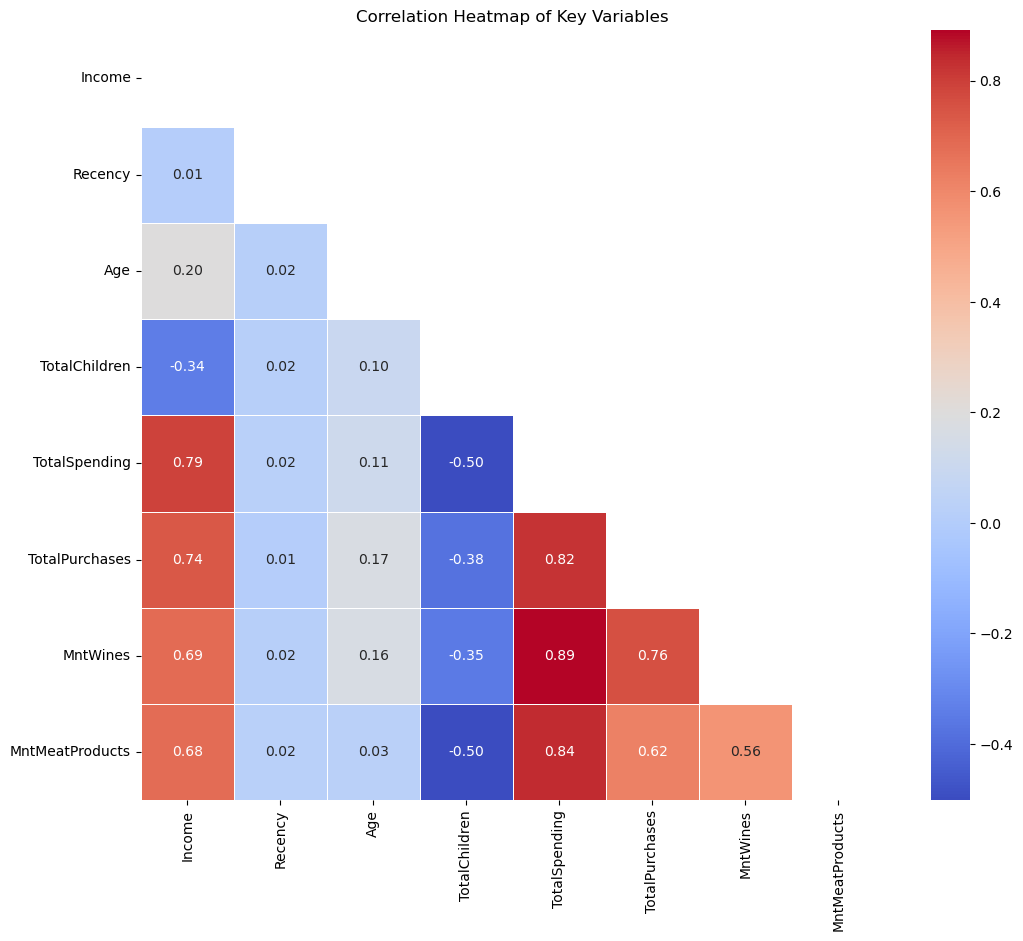

In [8]:
# --- Correlation Heatmap ---
# A heatmap is an excellent tool to quickly visualize the relationships between numerical variables.
# We'll generate one to see which variables are correlated. 
# Define the columns to include in the correlation matrix
columns_for_corr = [
    'Income', 'Recency', 'Age', 'TotalChildren',
    'TotalSpending', 'TotalPurchases', 'MntWines', 'MntMeatProducts'
]

# We Select only chosen columns for the correlation matrix
corr_matrix = df_clean[columns_for_corr].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct annotations
sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,      # Show the correlation values
            fmt='.2f',       # Format values to 2 decimal places
            cmap='coolwarm',
            linewidths=.5)

plt.title('Correlation Heatmap of Key Variables')
plt.show()




6• Hypothesis Testing
#
We will now test the four hypotheses provided in the project description using statistical tests. For each hypothesis, we'll state our findings clearly. A p-value of less than 0.05 will be considered statistically significant.




In [10]:
from scipy.stats import ttest_ind

# 6.1 Hypothesis 1: Older individuals prefer in-store shopping.
age_median = df_clean['Age'].median()
older_group = df_clean[df_clean['Age'] >= age_median]['NumStorePurchases']
younger_group = df_clean[df_clean['Age'] < age_median]['NumStorePurchases']

stat, p_value = ttest_ind(older_group, younger_group)
print(f"## Hypothesis 1: Older vs. Younger In-Store Purchases ##")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: True ✅. The difference is statistically significant. Older customers make more store purchases.")
else:
    print("Result: False ❌. There is no significant difference.")

# 6.2 Hypothesis 2: Customers with children prefer online shopping.
with_children = df_clean[df_clean['TotalChildren'] > 0]['NumWebPurchases']
no_children = df_clean[df_clean['TotalChildren'] == 0]['NumWebPurchases']

stat, p_value = ttest_ind(with_children, no_children)
print(f"\n## Hypothesis 2: Children vs. Online Purchases ##")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05 and with_children.mean() > no_children.mean():
    print("Result: True ✅. Customers with children make significantly more web purchases.")
else:
    print("Result: False ❌. The hypothesis is not supported. In fact, customers without children make more web purchases.")

# 6.3 Hypothesis 3: In-store sales are cannibalized by other channels.
# Corrected line using .loc to prevent SettingWithCopyWarning
df_clean.loc[:, 'OtherChannelsPurchases'] = df_clean['NumWebPurchases'] + df_clean['NumCatalogPurchases']
correlation = df_clean['NumStorePurchases'].corr(df_clean['OtherChannelsPurchases'])
print(f"\n## Hypothesis 3: Cannibalization of In-Store Sales ##")
print(f"Correlation between in-store and other channels: {correlation:.4f}")
if correlation < -0.2:
    print("Result: True ✅. There is a negative correlation, suggesting cannibalization.")
else:
    print("Result: False ❌. There is a positive correlation, suggesting channels are complementary.")

# 6.4 Hypothesis 4: The US outperforms the rest of the world in purchases.
us_purchases = df_clean[df_clean['Country'] == 'US']['TotalPurchases']
row_purchases = df_clean[df_clean['Country'] != 'US']['TotalPurchases']

stat, p_value = ttest_ind(us_purchases, row_purchases)
print(f"\n## Hypothesis 4: US vs. Rest of World Purchases ##")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05 and us_purchases.mean() > row_purchases.mean():
    print("Result: True ✅. The US has significantly higher total purchase volumes.")
else:
    print("Result: False ❌. There is no statistically significant difference.")

## Hypothesis 1: Older vs. Younger In-Store Purchases ##
P-value: 0.0000
Result: True ✅. The difference is statistically significant. Older customers make more store purchases.

## Hypothesis 2: Children vs. Online Purchases ##
P-value: 0.0010
Result: False ❌. The hypothesis is not supported. In fact, customers without children make more web purchases.

## Hypothesis 3: Cannibalization of In-Store Sales ##
Correlation between in-store and other channels: 0.6152
Result: False ❌. There is a positive correlation, suggesting channels are complementary.

## Hypothesis 4: US vs. Rest of World Purchases ##
P-value: 0.1508
Result: False ❌. There is no statistically significant difference.



7. Visual Analysis and Insights
#
Finally, we'll create visualizations to answer specific business questions about product performance, campaign engagement, and customer demographics.




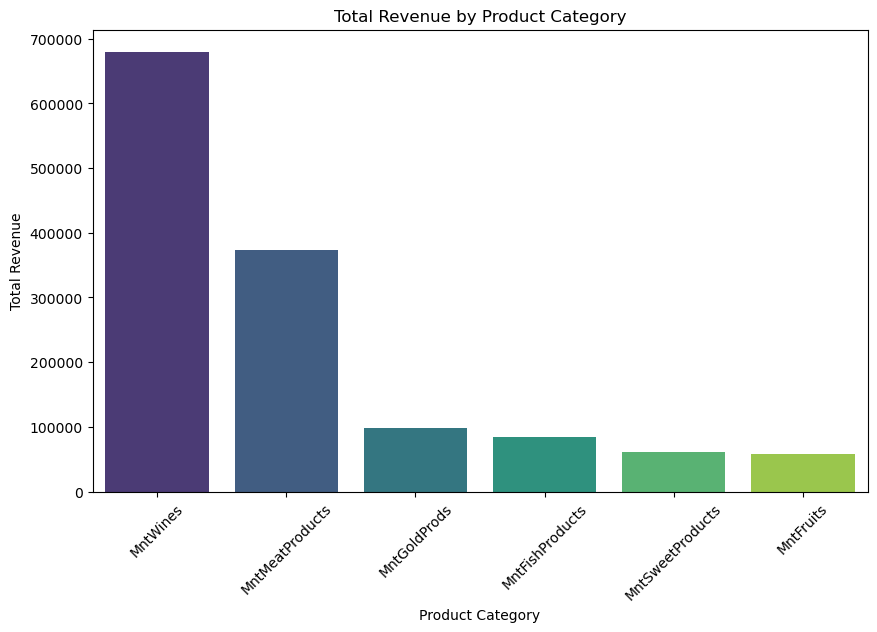

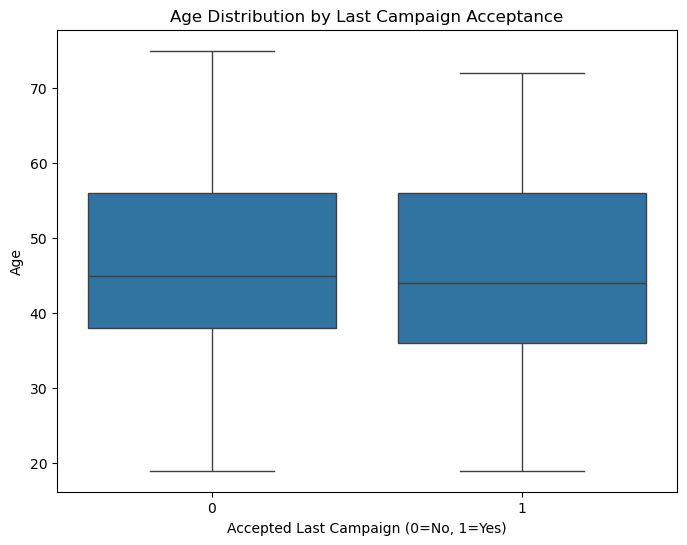

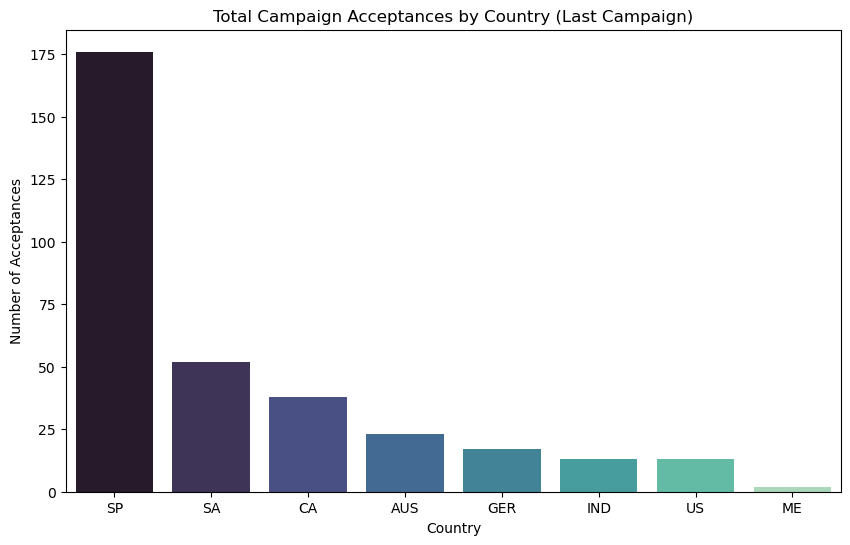

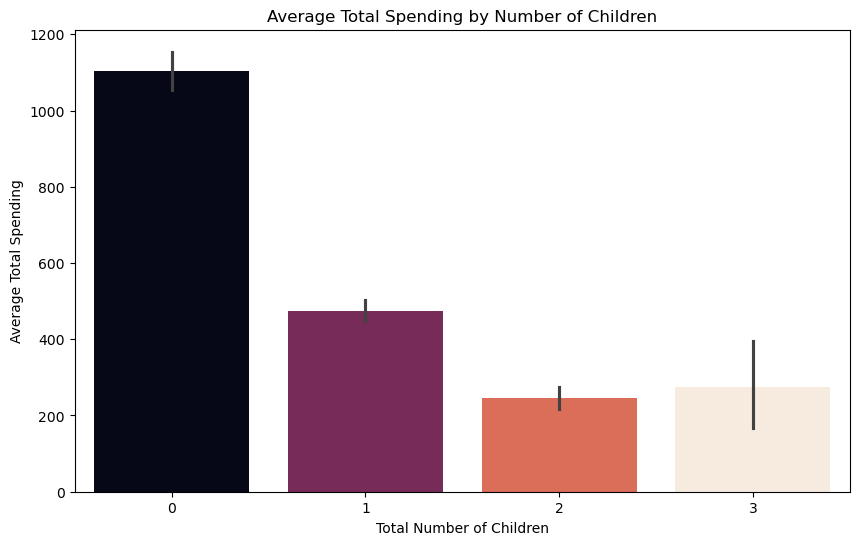

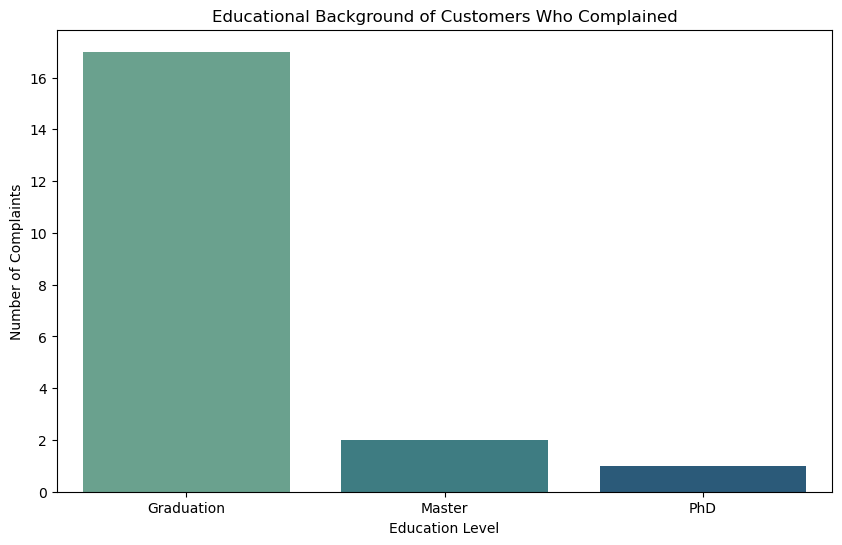

In [11]:
# 7.1 Top-Performing Products
products = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
product_spending = df_clean[products].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_spending.index, y=product_spending.values, hue=product_spending.index, palette='viridis', legend=False)
plt.title('Total Revenue by Product Category')
plt.ylabel('Total Revenue')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.show()

# 7.2 Age and Last Campaign Acceptance
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response', y='Age', data=df_clean)
plt.title('Age Distribution by Last Campaign Acceptance')
plt.xlabel('Accepted Last Campaign (0=No, 1=Yes)')
plt.ylabel('Age')
plt.show()

# 7.3 Country with Highest Campaign Acceptance
country_acceptance = df_clean.groupby('Country')['Response'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_acceptance.index, y=country_acceptance.values, hue=country_acceptance.index, palette='mako', legend=False)
plt.title('Total Campaign Acceptances by Country (Last Campaign)')
plt.ylabel('Number of Acceptances')
plt.xlabel('Country')
plt.show()

# 7.4 Number of Children and Total Expenditure
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalChildren', y='TotalSpending', data=df_clean, hue='TotalChildren', palette='rocket', legend=False)
plt.title('Average Total Spending by Number of Children')
plt.ylabel('Average Total Spending')
plt.xlabel('Total Number of Children')
plt.show()

# 7.5 Educational Background of Complainants
complaints_df = df_clean[df_clean['Complain'] == 1]
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', data=complaints_df, order=complaints_df['Education'].value_counts().index, hue='Education', palette='crest', legend=False)
plt.title('Educational Background of Customers Who Complained')
plt.ylabel('Number of Complaints')
plt.xlabel('Education Level')
plt.show()